# Modelos básicos para CGM

el siguiente notebook tiene por finalidad mostrar los avances realizados en la modelación. Para ello se mostrará el modo de evaluar cada uno de los modelos. Posterior a ello, se describirá cada modelo, realizará la prueba, se mostrará un gráfico con la señal real y la proyección y calculará la función que evalua el desempeño del mismo.

Lo primero es importa las librerías y cargar la base de datos

In [1]:
# Importamos las librerias necesarias para trabajar
from statsmodels.regression.linear_model import yule_walker
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from numpy.fft import fft, fftfreq, fftshift
from datetime import time
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mysql.connector
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import copy
import sklearn

# Seteamos el estilo de los graficos
sns.set(style="whitegrid")

# Configuramos los graficos con latex
plt.rc('text', usetex=True)

In [2]:
# Abrimos la base de datos
mydb = mysql.connector.connect(
    host='localhost',
    user='root',
    password='7461143',
    database='datos_ordenados'
)

# Extraemos la informacion en un dataframe
df = pd.read_sql("SELECT * FROM cgm_ordenados", mydb)   # Cargamos todos los datos 
#df.drop('id', axis=1, inplace=True)                   # Eliminamos el indice
df.set_index('datetime', inplace=True)                # Definimos datetime como indice
df.sort_index(inplace=True)                           # Ordenamos en base a datetime
# Mostramos los resultados
print('Tamano de la tabla: {} filas y {} columnas'.format(df.shape[0], df.shape[1]))
df.head(3)

Tamano de la tabla: 1728 filas y 6 columnas


,sensor_glucose,sensor_calibration_bg,meal,basal_insulin,bolus_insulin,exercise
datetime,,,,,,
2020-01-24 17:00:00,NaN,125.0,NaN,NaN,NaN,NaN
2020-01-24 17:05:00,126.0,NaN,NaN,NaN,NaN,NaN
2020-01-24 17:10:00,128.0,NaN,NaN,NaN,NaN,NaN


# 1 - Función $V_N$

El diseño de modelo busca realizar una predicción a futuro de 30 minutos. Dado que el periodo de muestreo del sensor es de 5 minutos, el predictor debe realizar una predicción de 6 pasos a futuro. Es decir que si se cuenta con información hasta $y_t$, se busca predecir hasta $\hat{y}_{t + 6}$. Luego, el error para el tiempo $t$ se calculará como $\varepsilon_t = y_t - \hat{y}_t$. Dado que se deben realizar 6 predicciones, el error será un vector de dimensión 6.

Sea el vector de error $\vec{\varepsilon}  = (\varepsilon_1, \varepsilon_2, \dots , \varepsilon_6)^T \in \mathbb{R}^6$, se calcula el desempeño como:

$$V_N = \cfrac{1}{N} \sum_{t=1}^{N} l [L(q)\varepsilon],$$

con:

* Filtro $L(q)$:

$$L(q) = 1$$

* Norma $l(\vec{\varepsilon})$

$$l(\varepsilon) = \frac{1}{2} \vec{\varepsilon}^T \cdot I \cdot \vec{\varepsilon} = \frac{1}{2} \sum_{i=1}^6 \varepsilon_i^2$$

In [3]:
# Definimos las funciones para la evaluacion de los errores

# filtro L(q):
def L(x):
    return x

# Norma l(epsilon):
def l(epsilon):
    return 0.5 * sum(epsilon ** 2)

# 2 - Modelo de persistencia

Este es el modelo más básico que se puede construir, y viene dado por:

$$\hat{y}_t = y_{t-1}$$

Para evaluar los modelos, se separarán los datos en un conjunto de entrenamiento y otro de testeo. El porcentaje escogido será 70% de training y 30% de testing.

In [4]:
# Parametros
k = 6                  # Numero de pasos a predecir. k=6 -> 6*5min = 30 minutos
train_percent = 0.7    # Porcentaje para el training

# Obtenemos los datos
y = copy.copy(df['sensor_glucose'].dropna())
y = y.rename('y')
# Creamos un dataframe con columnas nan para los k pasos a predecir 
data = pd.DataFrame(y)
for i in range(k):
    data['{}-step'.format(i + 1)] = np.nan

# Dividimos los datos de entrenamiento
n = round(train_percent * len(data))
train, test = data[:n], data[n:]

# Modelo de persistencia
def model_persistence(x):
    return x

# Validacion de paso adelante
# Iteramos para las filas
for i in range(1, train.shape[0]):
    date = train.index[i]
    date_prev = train.index[i - 1]
    for j in range(k):
        columna = train.columns[j + 1]
        columna_prev = train.columns[j]
        train[columna][date] = model_persistence(train[columna_prev][date_prev])
        
for i in range(1, test.shape[0]):
    date = test.index[i]
    date_prev = test.index[i - 1]
    for j in range(k):
        columna = test.columns[j + 1]
        columna_prev = test.columns[j]
        test[columna][date] = model_persistence(test[columna_prev][date_prev])

C:\Users\Particular\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


## Graficamos parte del set de testing para la señal

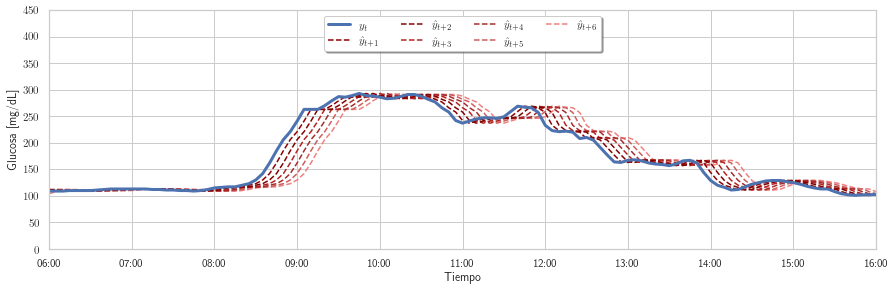

In [5]:
# Parametros
f_ini = pd.Timestamp('2020-01-29 06:00:00')
f_fin = pd.Timestamp('2020-01-29 16:00:00')

# Graficamos
fig, ax = plt.subplots()

ax.plot(test['6-step'][f_ini: f_fin], color='lightcoral', 
        linestyle='--', label='$\hat{y}_{t + 6}$')
ax.plot(test['5-step'][f_ini: f_fin], color='indianred', 
        linestyle='--', label='$\hat{y}_{t + 5}$')
ax.plot(test['4-step'][f_ini: f_fin], color='brown', 
        linestyle='--', label='$\hat{y}_{t + 4}$')
ax.plot(test['3-step'][f_ini: f_fin], color='firebrick', 
        linestyle='--', label='$\hat{y}_{t + 3}$')
ax.plot(test['2-step'][f_ini: f_fin], color='maroon', 
        linestyle='--', label='$\hat{y}_{t + 2}$')
ax.plot(test['1-step'][f_ini: f_fin], color='darkred', 
        linestyle='--', label='$\hat{y}_{t + 1}$')
ax.plot(test['y'][f_ini: f_fin], color='C0', linewidth=3.0
       , label='$y_{t}$')

# Parametros
ax.grid(True)
ax.set_ylim([0, 450])
ax.set_xlim([f_ini, f_fin])
ax.set_ylabel('Glucosa [mg/dL]')
ax.set_xlabel('Tiempo')

# leyenda
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc= 'upper center', ncol=4, fancybox=True, shadow=True)

# Formato de las fechas
date_form = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_form)

y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

## Desempeño de la estimación

In [6]:
# Calculamos los errores para cada ventana de tiempo en el train
train_error = list()
for column in train.columns.drop('y'):
    err_buff = train['y'] - train[column]
    err_buff = err_buff.rename('err_{}'.format(column[0]))
    train_error.append(err_buff)
train_error = pd.concat(train_error, axis=1)
train_error.dropna(inplace=True)

# Calculamos V_N
V_train = train_error.apply(l, axis=1)
V_train = 1 / len(V_train) * sum(V_train)
print('V_train: {}'.format(V_train))

V_train: 1733.5175000000002


In [7]:
# Calculamos los errores para cada ventana de tiempo en el train
test_error = list()
for column in train.columns.drop('y'):
    err_buff = test['y'] - test[column]
    err_buff = err_buff.rename('err_{}'.format(column[0]))
    test_error.append(err_buff)
test_error = pd.concat(test_error, axis=1)
test_error.dropna(inplace=True)

# Calculamos V_N
V_test = test_error.apply(l, axis=1)
V_test = 1 / len(V_test) * sum(V_test)
print('V_testing: {}'.format(V_test))

V_testing: 1323.9716242661448


## 3 - Modelo AR

El siguiente modelo a considerar es un modelo autoregresivo. Este tiene la forma:

$$\hat{y}_{t} = \phi_0 + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_{n_a} y_{t-n_a} + \varepsilon_t$$

Antes de realizar y calcular los valores, se grafica la función de autocorrelación de la señal. Con esta información, podemos notar que existe una alta correlación dentro de los primeros 16 valores aproximadamente ($\rho > 0.6$)

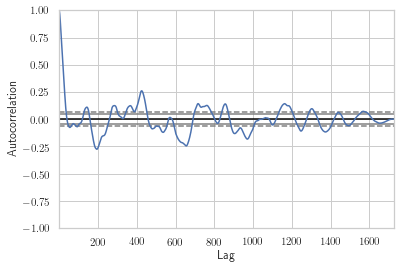

In [82]:
## Primero hacemos un grafico de autocorrelacion
y = copy.copy(df['sensor_glucose']).interpolate().dropna()
y.index.freq = pd.infer_freq(y.index)
ax = pd.plotting.autocorrelation_plot(y.dropna())
ax.grid(True)

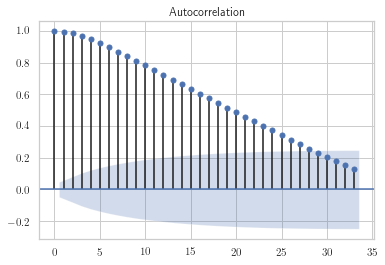

In [9]:
plot_acf(y)
plt.show()

Es decir que los candidatos para un modelo AR son todas las familias de funciones tal que $n_a \leq 16$. Utilizando la ecuación de Yule-Walker podemos estimar un nuevo modelo.

## Caso AR($n_a = 1$)

Como se mostrará más adelante, el caso con mejor desempeño es para $n_a = 1$. Usaremos este valor como ejemplo para el computo de los valores

In [22]:
from statsmodels.regression.linear_model import yule_walker
# Parametros
k = 6                  # Numero de pasos a predecir. k=6 -> 6*5min = 30 minutos
train_percent = 0.7    # Porcentaje para el training
lag = 1                # Lag en este caso es n_a

# Obtenemos los datos
y = y.rename('y')

# Creamos un dataframe con columnas nan para los k pasos a predecir 
data = pd.DataFrame(y)

# Dividimos los datos de entrenamiento
n = round(train_percent * len(data))
train, test = data[:n], data[n:]

# Entrenamos la regresion
theta_vect, theta_0 = yule_walker(train, lag, method='mle')

print('parametros: ')
print(' theta_0: {:0.4f}'.format(theta_0))
for i in range(len(theta_vect)):
    print(' theta_{}: {:0.4f}'.format(i + 1, theta_vect[i]))

# Generamos la funcion para evaluar la senal
def AR_fit(x):
    global theta_0, theta_vect
    x = x[-lag:]
    return theta_0 + sum(np.array(x) * np.flip(np.array(theta_vect)))

parametros: 
 theta_0: 7.3460
 theta_1: 0.9956


In [27]:
# Generamos un dataframe con entradas pasadas
y_df = y
for i in range(len(theta_vect)):
    y_des = y.shift(i + 1)
    y_des = y_des.rename('y-{}'.format(i+1))
    y_df = pd.concat([y_des, y_df], axis=1)
# Eliminamos todas las filas que contengan algun nan
y_df.dropna(inplace=True)

for i in range(k):
    y_df['y+{}'.format(i+1)] = y_df.apply(AR_fit, axis=1)
    y_df['y+{}'.format(i+1)] = y_df['y+{}'.format(i+1)].shift(1)
    
# Separamos los dataframes
y_hat_train, y_hat_test = y_df[:n], y_df[n:]

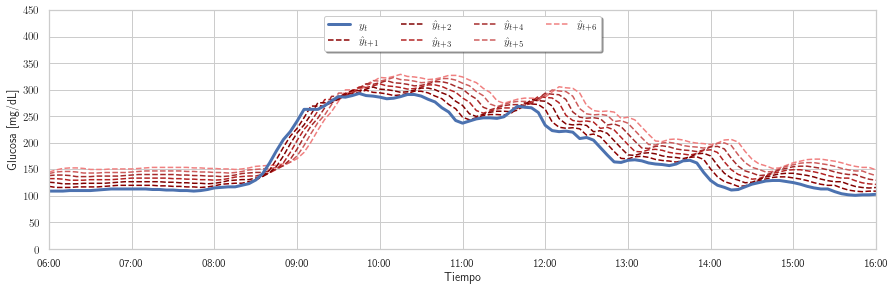

In [28]:
# Parametros
f_ini = pd.Timestamp('2020-01-29 06:00:00')
f_fin = pd.Timestamp('2020-01-29 16:00:00')

# Graficamos
fig, ax = plt.subplots()

ax.plot(y_hat_test['y+6'][f_ini: f_fin], color='lightcoral', 
        linestyle='--', label='$\hat{y}_{t + 6}$')
ax.plot(y_hat_test['y+5'][f_ini: f_fin], color='indianred', 
        linestyle='--', label='$\hat{y}_{t + 5}$')
ax.plot(y_hat_test['y+4'][f_ini: f_fin], color='brown', 
        linestyle='--', label='$\hat{y}_{t + 4}$')
ax.plot(y_hat_test['y+3'][f_ini: f_fin], color='firebrick', 
        linestyle='--', label='$\hat{y}_{t + 3}$')
ax.plot(y_hat_test['y+2'][f_ini: f_fin], color='maroon', 
        linestyle='--', label='$\hat{y}_{t + 2}$')
ax.plot(y_hat_test['y+1'][f_ini: f_fin], color='darkred', 
        linestyle='--', label='$\hat{y}_{t + 1}$')
ax.plot(y_hat_test['y'][f_ini: f_fin], color='C0', linewidth=3.0
       , label='$y_{t}$')

# Parametros
ax.grid(True)
ax.set_ylim([0, 450])
ax.set_xlim([f_ini, f_fin])
ax.set_ylabel('Glucosa [mg/dL]')
ax.set_xlabel('Tiempo')

# leyenda
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc= 'upper center', ncol=4, fancybox=True, shadow=True)

# Formato de las fechas
date_form = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_form)

y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

In [29]:
# Calculamos los errores para cada ventana de tiempo en el train
test_error = list()
for column in y_hat_train.columns[-6:]:
    err_buff = y_hat_train['y'] - y_hat_train[column]
    err_buff = err_buff.rename('err_{}'.format(column[0]))
    test_error.append(err_buff)
test_error = pd.concat(test_error, axis=1)
test_error.dropna(inplace=True)

# Calculamos V_N
V_train = test_error.apply(l, axis=1)
V_train = 1 / len(V_train) * sum(V_train)
print('V_train: {}'.format(V_train))

V_train: 3588.242161868364


In [30]:
# Calculamos los errores para cada ventana de tiempo en el train
test_error = list()
for column in y_hat_test.columns[-6:]:
    err_buff = y_hat_test['y'] - y_hat_test[column]
    err_buff = err_buff.rename('err_{}'.format(column[0]))
    test_error.append(err_buff)
test_error = pd.concat(test_error, axis=1)
test_error.dropna(inplace=True)

# Calculamos V_N
V_test = test_error.apply(l, axis=1)
V_test = 1 / len(V_test) * sum(V_test)
print('V_test: {}'.format(V_test))

V_test: 3216.067120318573


Ahora, iteramos para los rangos definidos previamente

In [66]:
V_train_list = list()
V_test_list = list()
lag_list = list()
for lag in range(1,40):
    #print('Simulacion para n_a: {}'.format(lag))
    # Parametros
    k = 6                  # Numero de pasos a predecir. k=6 -> 6*5min = 30 minutos
    train_percent = 0.7    # Porcentaje para el training
    # lag = 4                # Lag en este caso es n_a

    # Obtenemos los datos
    y = y.rename('y')

    # Creamos un dataframe con columnas nan para los k pasos a predecir 
    data = pd.DataFrame(y)

    # Dividimos los datos de entrenamiento
    n = round(train_percent * len(data))
    train, test = data[:n], data[n:]

    # Entrenamos la regresion
    theta_vect, theta_0 = yule_walker(train, lag, method='mle')

    # Generamos la funcion para evaluar la senal
    def AR_fit(x):
        global theta_0, theta_vect
        x = x[-lag:]
        return theta_0 + sum(np.array(x) * np.flip(np.array(theta_vect)))

    ######################################################################################33
    # Generamos un dataframe con entradas pasadas
    y_df = y
    for i in range(len(theta_vect)):
        y_des = y.shift(i + 1)
        y_des = y_des.rename('y-{}'.format(i+1))
        y_df = pd.concat([y_des, y_df], axis=1)
    # Eliminamos todas las filas que contengan algun nan
    y_df.dropna(inplace=True)

    for i in range(k):
        y_df['y+{}'.format(i+1)] = y_df.apply(AR_fit, axis=1)
        
    for i in range(k):
        col_buff = y_df.iloc[:, -(i+1)]
        y_df.iloc[:, -(i+1)] = col_buff.shift(k - i)
    
    # Separamos los dataframes
    y_hat_train, y_hat_test = y_df[:n], y_df[n:]

    ######################################################################################
    # Calculamos los errores para cada ventana de tiempo en el train
    test_error = list()
    for column in y_hat_train.columns[-6:]:
        err_buff = y_hat_train['y'] - y_hat_train[column]
        err_buff = err_buff.rename('err_{}'.format(column[0]))
        test_error.append(err_buff)
    test_error = pd.concat(test_error, axis=1)
    test_error.dropna(inplace=True)

    # Calculamos V_N
    V_train = test_error.apply(l, axis=1)
    V_train = 1 / len(V_train) * sum(V_train)
    #print('V_train: {}'.format(V_train))

    ######################################################################################
    # Calculamos los errores para cada ventana de tiempo en el train
    test_error = list()
    for column in y_hat_test.columns[-6:]:
        err_buff = y_hat_test['y'] - y_hat_test[column]
        err_buff = err_buff.rename('err_{}'.format(column[0]))
        test_error.append(err_buff)
    test_error = pd.concat(test_error, axis=1)
    test_error.dropna(inplace=True)

    # Calculamos V_N
    V_test = test_error.apply(l, axis=1)
    V_test = 1 / len(V_test) * sum(V_test)
    #print('V_test: {}'.format(V_test))

    ## Agregamos a las listas
    V_train_list.append(V_train)
    V_test_list.append(V_test)
    lag_list.append(lag)

In [67]:
V_N = pd.concat([pd.Series(V_train_list), pd.Series(V_test_list), pd.Series(lag_list)], axis=1)
V_N.rename(columns={0:'V_train', 1:'V_test', 2:'n_a'}, inplace=True)
V_N.set_index('n_a', inplace=True)
V_N

,V_train,V_test
n_a,,
1,3588.242162,3216.067120
2,3066.370646,3140.993062
3,2790.017182,2898.599786
4,2615.119760,2740.931047
5,2798.557063,2929.180710
6,2911.757943,3053.938813
7,2680.424978,2811.178078
8,2750.582379,2894.943758
9,2711.128675,2860.209058


Graficamos el desempeño. Notamos que este valor alcanza su mínimo para $n_a = 1$

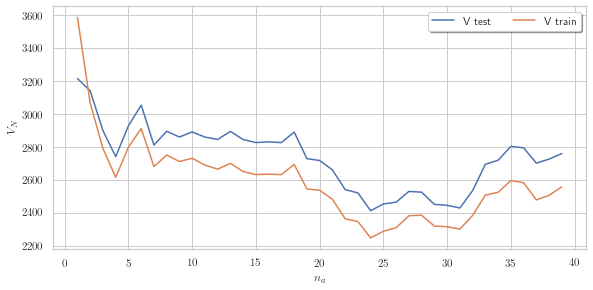

In [73]:
fig, ax = plt.subplots()

ax.plot(lag_list, V_test_list)
ax.plot(lag_list, V_train_list)

# Parametros
ax.grid(True, which='minor', linestyle='-')
#ax.set_ylim([0, 3000])
ax.set_ylabel('$V_N$')
ax.set_xlabel('$n_a$')
ax.legend(['V test', 'V train'], ncol=4, fancybox=True, shadow=True)

y_size = 4.2
x_size = 2 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

Mostramos un gráfico para un $n_a$ cualquiera. Particularmente para $n_a=7$

parametros: 
 theta_0: 4.5882
 theta_1: 1.7030
 theta_2: -0.6675
 theta_3: 0.0569
 theta_4: -0.1362
 theta_5: -0.0997
 theta_6: 0.2811
 theta_7: -0.2036
 theta_8: 0.0824
 theta_9: -0.0421
 theta_10: 0.0206
 theta_11: 0.0285
 theta_12: -0.0839
 theta_13: 0.0766
 theta_14: -0.0094
 theta_15: -0.0282
 theta_16: 0.0408
 theta_17: -0.1119
 theta_18: 0.1494
 theta_19: -0.0814
 theta_20: -0.0022
 theta_21: 0.0606
 theta_22: -0.0681
 theta_23: 0.0695
 theta_24: -0.0456


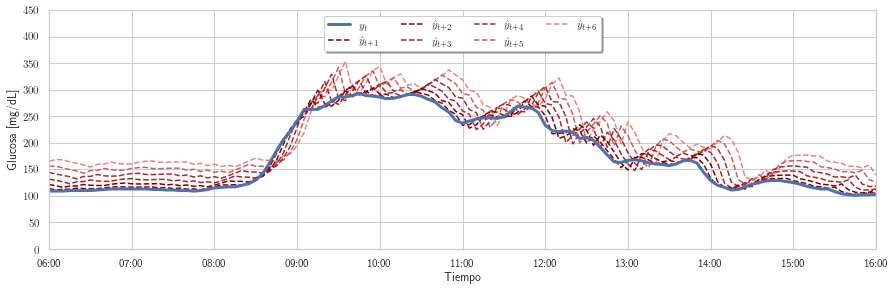

In [92]:
from statsmodels.regression.linear_model import yule_walker
# Parametros
k = 6                  # Numero de pasos a predecir. k=6 -> 6*5min = 30 minutos
train_percent = 0.7    # Porcentaje para el training
lag = 24                # Lag en este caso es n_a

# Obtenemos los datos
y = y.rename('y')

# Creamos un dataframe con columnas nan para los k pasos a predecir 
data = pd.DataFrame(y)

# Dividimos los datos de entrenamiento
n = round(train_percent * len(data))
train, test = data[:n], data[n:]

# Entrenamos la regresion
theta_vect, theta_0 = yule_walker(train, lag, method='mle')

print('parametros: ')
print(' theta_0: {:0.4f}'.format(theta_0))
for i in range(len(theta_vect)):
    print(' theta_{}: {:0.4f}'.format(i + 1, theta_vect[i]))

# Generamos la funcion para evaluar la senal
def AR_fit(x):
    global theta_0, theta_vect
    x = x[-lag:]
    return theta_0 + sum(np.array(x) * np.flip(np.array(theta_vect)))

# Generamos un dataframe con entradas pasadas
y_df = y
for i in range(len(theta_vect)):
    y_des = y.shift(i + 1)
    y_des = y_des.rename('y-{}'.format(i+1))
    y_df = pd.concat([y_des, y_df], axis=1)
# Eliminamos todas las filas que contengan algun nan
y_df.dropna(inplace=True)

for i in range(k):
    y_df['y+{}'.format(i+1)] = y_df.apply(AR_fit, axis=1)

for i in range(k):
    col_buff = y_df.iloc[:, -(i+1)]
    y_df.iloc[:, -(i+1)] = col_buff.shift(k - i)
    
# Separamos los dataframes
y_hat_train, y_hat_test = y_df[:n], y_df[n:]

# Parametros
f_ini = pd.Timestamp('2020-01-29 06:00:00')
f_fin = pd.Timestamp('2020-01-29 16:00:00')

# Graficamos
fig, ax = plt.subplots()

ax.plot(y_hat_test['y+6'][f_ini: f_fin], color='lightcoral', 
        linestyle='--', label='$\hat{y}_{t + 6}$')
ax.plot(y_hat_test['y+5'][f_ini: f_fin], color='indianred', 
        linestyle='--', label='$\hat{y}_{t + 5}$')
ax.plot(y_hat_test['y+4'][f_ini: f_fin], color='brown', 
        linestyle='--', label='$\hat{y}_{t + 4}$')
ax.plot(y_hat_test['y+3'][f_ini: f_fin], color='firebrick', 
        linestyle='--', label='$\hat{y}_{t + 3}$')
ax.plot(y_hat_test['y+2'][f_ini: f_fin], color='maroon', 
        linestyle='--', label='$\hat{y}_{t + 2}$')
ax.plot(y_hat_test['y+1'][f_ini: f_fin], color='darkred', 
        linestyle='--', label='$\hat{y}_{t + 1}$')
ax.plot(y_hat_test['y'][f_ini: f_fin], color='C0', linewidth=3.0
       , label='$y_{t}$')

# Parametros
ax.grid(True)
ax.set_ylim([0, 450])
ax.set_xlim([f_ini, f_fin])
ax.set_ylabel('Glucosa [mg/dL]')
ax.set_xlabel('Tiempo')

# leyenda
handles, labels = ax.get_legend_handles_labels()
handles.reverse()
labels.reverse()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc= 'upper center', ncol=4, fancybox=True, shadow=True)

# Formato de las fechas
date_form = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_form)

y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()